In [0]:
!pip install tensorflow==2.0.0-alpha0 

In [0]:
!pip install  tfp-nightly

# 1.2 Two-dimenstional data

In this problem, you will work with bivariate data of the form $\textbf{x}=(x_{1},x_{2})$
, where $x_{1},x_{2}∈\{0,1,...,199\}$
. In the file called `distribution.npy`, you are provided with a 2-dimensional array of floating point numbers representing the joint distribution of $x$
 : element $(i,j)$
 of this array is the joint probability $p_{data}(x_{1}=i,x_{2}=j)$
.

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import regularizers
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
tf.__version__

'2.0.0-alpha0'

In [0]:
np.random.seed(0)
tf.random.set_seed(0)
NUM_EPOCHS = 30
BATCH_SIZE = 256

In [0]:
data = np.load('distribution.npy')

In [0]:
def sample_data2():
    count = 100000
    data = np.load('distribution.npy')
    xs = np.random.choice(40000, count, p=data.ravel())
    return np.array([(x//200, x%200) for x in xs])
data2 = sample_data2()

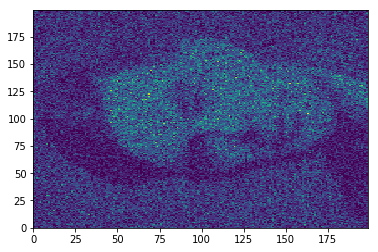

In [0]:
plt.hist2d(*tuple(zip(*data2)), bins=[200,200])
plt.show()

In [0]:
# Prepare for the train/val data set.
train = data2[:int(len(data2)*0.8)]
val = data2[int(len(data2)*0.8):]
train_dset = tf.data.Dataset.from_tensor_slices(train).\
                                repeat(1).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices(val).\
                                    batch(BATCH_SIZE)

In [0]:
theta = tf.Variable(tf.zeros(200), dtype=tf.float32, name='theta')

@tf.function
def p(x):
    """Calculate the softmax probaility of the corresponding class x.
    Args: 
        x: A batch of `int` in the range `[0,199]` (inclusive)
    Returns:
        A batch of `float` values representing the softmax prob of each input class
    """
    dist = tfp.distributions.Categorical(probs=tf.math.softmax(theta))
    return dist.prob(x)

@tf.function
def softmaxLoss(x):
    return tf.reduce_mean(-tf.math.log(p(x)))

def nll(prob, x):
    dist = tfp.distributions.Categorical(probs=prob)
    return tf.cast(tf.reduce_mean(-dist.log_prob(x)), tf.float32)

In [0]:
cond_prob = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(200,), activation='relu', kernel_regularizer=regularizers.l2(10)),
    tf.keras.layers.Dense(32,  activation='relu', kernel_regularizer=regularizers.l2(10)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(200, activation='softmax',kernel_regularizer=regularizers.l2(1))
])

In [0]:
# Create metrics
loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
train_loss_history = []
val_loss_history = []

# Define train/val steps
@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        cond_probs_x2 = cond_prob(tf.one_hot(x1, 200), training=True)
        log_loss = softmaxLoss(x1) + nll(cond_probs_x2, x2) 
    var = [theta] + cond_prob.trainable_variables
    gradients = tape.gradient(log_loss, var)
    optimizer.apply_gradients(zip(gradients, var))
    # Update the metrics
    loss_metric.update_state(log_loss)
 

@tf.function
def val_step(x1, x2):
    cond_probs_x2 = cond_prob(tf.one_hot(x1, 200), training = False)
    log_loss = softmaxLoss(x1) + nll(cond_probs_x2, x2)
    # Update the metrics
    val_loss_metric.update_state(log_loss)

In [0]:
for epoch in range(NUM_EPOCHS):
    # Reset the metrics
    loss_metric.reset_states()
    train_dset = train_dset.shuffle(buffer_size=10000)
    for inputs in train_dset:
        x1 = inputs[:,0]
        x2 = inputs[:,1]
        train_step(x1, x2)
        
    # Repeat the same process for val set
    val_loss_metric.reset_states()
    for inputs in val_dset:
        x1 = inputs[:,0]
        x2 = inputs[:,1]
        val_step(x1, x2)
    # Get the metric results
    mean_loss = loss_metric.result().numpy()
    mean_val_loss = val_loss_metric.result().numpy()
    mean_loss = np.log2(np.exp(mean_loss))
    mean_val_loss = np.log2(np.exp(mean_val_loss))
    train_loss_history.append(mean_loss)
    val_loss_history.append(mean_val_loss)

    print('Epoch: ', epoch)
    print('  train loss:     {:.3f}'.format(mean_loss))
    print('  val loss: {:.3f}'.format(mean_val_loss))

Epoch:  0
  train loss:     15.262
  val loss: 15.237
Epoch:  1
  train loss:     15.233
  val loss: 15.224
Epoch:  2
  train loss:     15.221
  val loss: 15.217
Epoch:  3
  train loss:     15.215
  val loss: 15.215
Epoch:  4
  train loss:     15.210
  val loss: 15.213
Epoch:  5
  train loss:     15.206
  val loss: 15.211
Epoch:  6
  train loss:     15.203
  val loss: 15.210
Epoch:  7
  train loss:     15.199
  val loss: 15.209
Epoch:  8
  train loss:     15.195
  val loss: 15.208
Epoch:  9
  train loss:     15.193
  val loss: 15.208
Epoch:  10
  train loss:     15.191
  val loss: 15.208
Epoch:  11
  train loss:     15.189
  val loss: 15.208
Epoch:  12
  train loss:     15.187
  val loss: 15.208
Epoch:  13
  train loss:     15.185
  val loss: 15.209
Epoch:  14
  train loss:     15.184
  val loss: 15.208
Epoch:  15
  train loss:     15.184
  val loss: 15.208
Epoch:  16
  train loss:     15.182
  val loss: 15.208
Epoch:  17
  train loss:     15.180
  val loss: 15.208
Epoch:  18
  train l

In [0]:
def plot_training_history(title, label, val_history, train_history, train_marker='.', val_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    train_plots = train_history
    val_plots = val_history
    num_train = len(train_plots)
    for i in range(num_train):
        label='train_loss'
        if labels is not None:
            label += str(labels[i])
        plt.plot(train_plots[i], train_marker, label=label)
    label='val_loss'
    if labels is not None:
        label += str(labels[0])
    plt.plot(val_plots, val_marker, label=label)
    plt.legend(loc='lower center', ncol=num_train+1) 

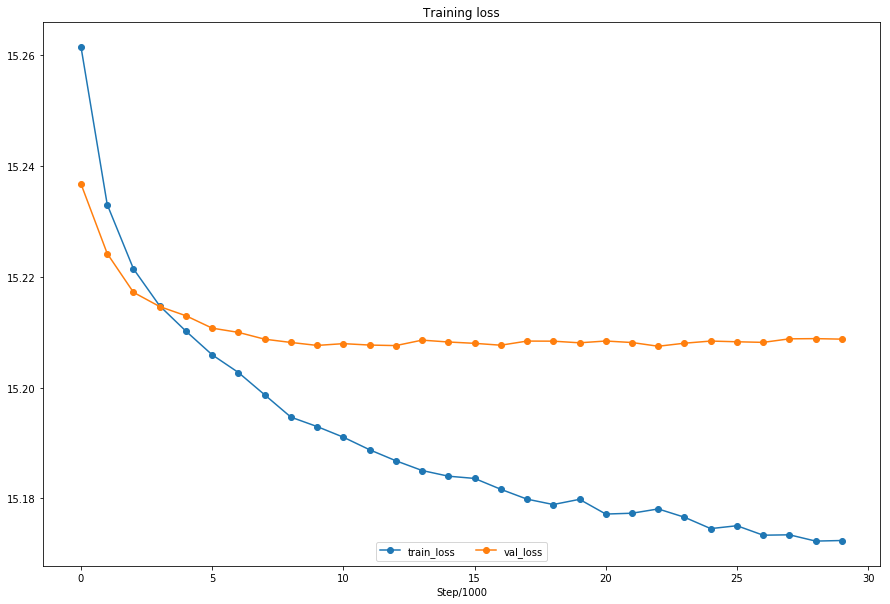

In [0]:
plot_training_history('Training loss','Step/1000', val_loss_history, [train_loss_history], 
                     train_marker='-o', val_marker='-o')
plt.gcf().set_size_inches(15, 10)
plt.show()

In [0]:
dist_x1 = tfp.distributions.Categorical(probs=tf.math.softmax(theta))
samples_x1 = [dist_x1.sample() for _ in range(100000)]

In [0]:
data3 = np.zeros_like(data)

In [28]:
data3.shape

(200, 200)

In [0]:
for i in range(200):
    prob_x1 = dist_x1.prob(i)
    logit = cond_prob(tf.one_hot([i], 200), training = False)[0]
    dist_x2 = tfp.distributions.Categorical(probs=logit)
    
    for j in range(200):
        prob = prob_x1 * dist_x2.prob(j)
        data3[i,j] = prob

In [0]:
def sample_data3():
    count = 1000000
    data = np.load('distribution.npy')
    xs = np.random.choice(40000, count, p=data3.ravel())
    return np.array([(x//200, x%200) for x in xs])
final_sample = sample_data3()

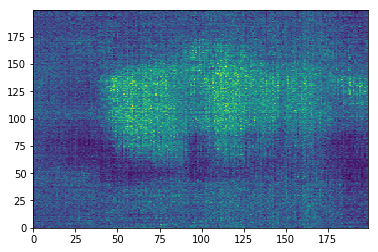

In [38]:
plt.hist2d(*tuple(zip(*final_sample)), bins=[200,200])
plt.show()